This notebook outlines the initial Exploratory Data Analysis (EDA) I conducted on the raw dataset `DataScientist_CaseStudy_Dataset.xlsx`, which comprises four sheets (sub-datasets): **Soc_Dem** (socio-demographic information), **Products_ActBalance** (product holdings and volumes), **Inflow_Outflow** (financial transactions), and **Sales_Revenue** (sales and revenue data). The first three sheets represent input features, while the last serves as the target. A thorough inspection and preprocessing of the data were performed to ensure model reliability.

**Duplicate Entry Check:** No duplicate records were found across any dataset.

**Null Value Analysis:** I Identified 28 clients present in `Soc_Dem` and `Products_ActBalance` but missing in `Inflow_Outflow`, indicating dormant accounts. I verified that all null values were legitimate (i.e., non-existent transactional records instead of missing), allowing me to replace NaN values with `0` where appropriate.


**Data Type Validation:** I checked for inconsistent data types; only `Sex` was found as a string, requiring label encoding.

**Outlier Detection & Treatment:** I detected heavy right-skew in continuous numerical features. I applied **Winsorization** on the upper extreme values, capping them at the 95th percentile. Also, I Identified clients under age 16 with substantial account activity. While potentially suspicious, I assumed these are valid data from european banks who allow registration of bank accounts to minors, keeping the entries within the dataset for later training.

**Feature Engineering:** I introduced three new features: `dormant` (flag for dormant accounts), `total_balance` (aggregated balance across accounts), and `credit_debit_ratio` (ratio of credit inflow to debit outflow).

**Categorical Encoding:** I applied label encoding to the `Sex` attribute for model compatibility.

**Feature Redundancy & Multicollinearity Analysis:** I identified high correlation between transaction/volume features and current account transaction/volume features, leading to the removal of redundant current account columns (`_CA` suffix).

**Class Imbalance Assessment:** I found class imbalance in the target labels and planned to address it via class-weight adjustments during modeling.

**Data Export & Next Steps:** I processed `X` (features) and `y` (target labels) and exported them to CSV files, serving as inputs for the modeling and optimization pipeline.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Import Data

In [2]:
df_soc_dem = pd.read_excel('./data/DataScientist_CaseStudy_Dataset.xlsx', sheet_name='Soc_Dem')
df_products_actbalance = pd.read_excel('./data/DataScientist_CaseStudy_Dataset.xlsx', sheet_name='Products_ActBalance')
df_inflow_outflow = pd.read_excel('./data/DataScientist_CaseStudy_Dataset.xlsx', sheet_name='Inflow_Outflow')
df_sales_revenues = pd.read_excel('./data/DataScientist_CaseStudy_Dataset.xlsx', sheet_name='Sales_Revenues')

print(f"Size of df_soc_dem: {df_soc_dem.shape}")
print(f"Size of df_products_actbalance: {df_products_actbalance.shape}")
print(f"Size of df_inflow_outflow: {df_inflow_outflow.shape}")
print(f"Size of df_sales_revenues: {df_sales_revenues.shape}")


Size of df_soc_dem: (1615, 4)
Size of df_products_actbalance: (1615, 13)
Size of df_inflow_outflow: (1587, 15)
Size of df_sales_revenues: (969, 7)


I immediately noticed that inflow_outflow is missing 28 clients

In [3]:
df_merged = df_soc_dem.merge(df_products_actbalance, on='Client', how='left')\
    .merge(df_inflow_outflow, on='Client', how='left')\
    .merge(df_sales_revenues, on='Client', how='left')\
    .sort_values(by='Client', ascending=True)\
    .reset_index(drop=True)

df_merged.to_csv('./data/df_merged.csv', index=False)


In [4]:
df_merged.head()

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1,F,51,7,1,NaN,NaN,1.0,NaN,NaN,...,30.0,3.0,12.0,9.0,1.0,0.0,0.0,26.972679,0.0,0.0
1,2,M,43,152,1,1.0,NaN,NaN,NaN,NaN,...,6.0,2.0,2.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,3,M,17,140,1,NaN,1.0,NaN,NaN,NaN,...,3.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,M,24,153,1,1.0,NaN,NaN,1.0,NaN,...,36.0,6.0,12.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN
4,5,F,58,200,1,1.0,NaN,NaN,NaN,NaN,...,41.0,4.0,17.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN


### Exploratory Data Analysis

#### I. Check for Duplicate Entries

In [5]:
duplicate_rows = df_merged[df_merged.duplicated()]
print(duplicate_rows)

Empty DataFrame
Columns: [Client, Sex, Age, Tenure, Count_CA, Count_SA, Count_MF, Count_OVD, Count_CC, Count_CL, ActBal_CA, ActBal_SA, ActBal_MF, ActBal_OVD, ActBal_CC, ActBal_CL, VolumeCred, VolumeCred_CA, TransactionsCred, TransactionsCred_CA, VolumeDeb, VolumeDeb_CA, VolumeDebCash_Card, VolumeDebCashless_Card, VolumeDeb_PaymentOrder, TransactionsDeb, TransactionsDeb_CA, TransactionsDebCash_Card, TransactionsDebCashless_Card, TransactionsDeb_PaymentOrder, Sale_MF, Sale_CC, Sale_CL, Revenue_MF, Revenue_CC, Revenue_CL]
Index: []

[0 rows x 36 columns]


#### II. Check for Nullity

Why are there 28 missing clients in df_inflow_outflow?

In [6]:
# Missing clients in inflow_outflow present in soc_dem and products_actbalance
missing_clients = df_soc_dem[~df_soc_dem.Client.isin(df_inflow_outflow.Client)].Client.values
df_missing_clients = df_merged[df_merged.Client.isin(missing_clients)]

# exporting to csv if needed for detailed inspection on excel
df_missing_clients.to_csv('./data/missing_clients.csv', index=False)

df_missing_clients

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
49,50,F,33,109,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,0.00
57,58,F,45,49,1,NaN,6.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,0.00
83,84,M,66,235,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
304,305,M,37,140,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
314,315,M,24,93,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,0.00
333,334,F,49,163,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,1.786786,0.00
354,355,M,43,36,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
376,377,M,38,167,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,0.00
513,514,M,77,129,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,0.00
521,522,F,47,129,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


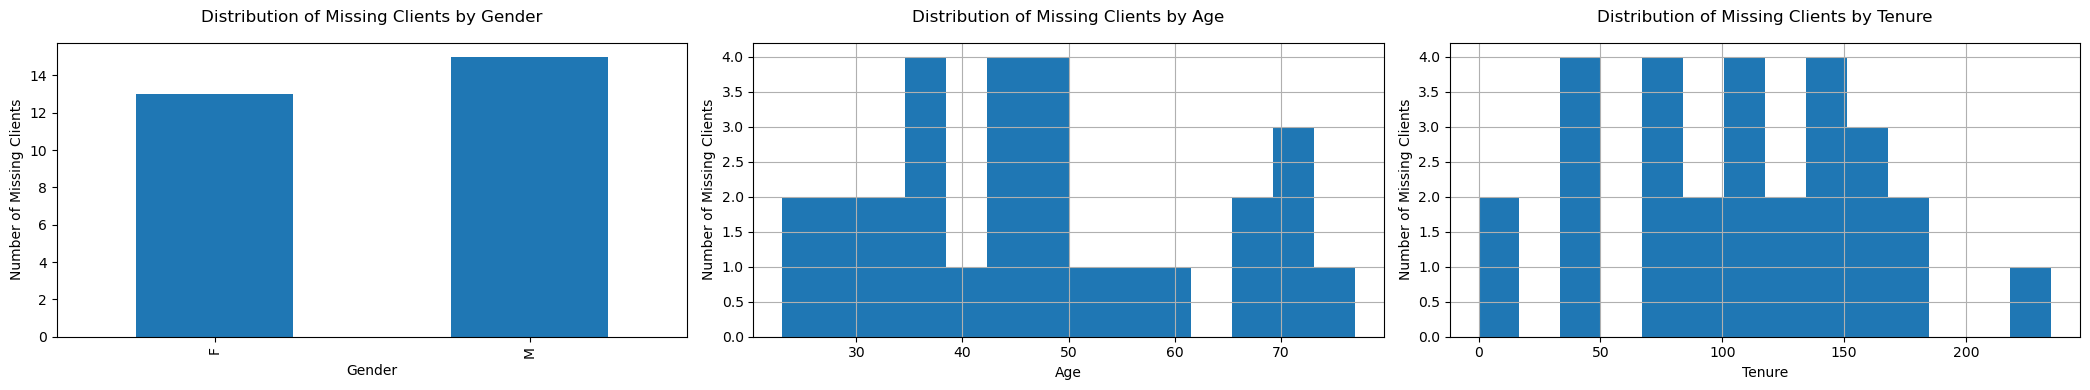

In [7]:
# Check for patterns in missing clients
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 4))

# Gender distribution
df_missing_clients.groupby('Sex')['Client'].count().plot.bar(ax=ax1)
ax1.set_title('Distribution of Missing Clients by Gender', pad=15)
ax1.set_xlabel('Gender')
ax1.set_ylabel('Number of Missing Clients')

# Age distribution
df_missing_clients['Age'].hist(bins=14, ax=ax2)
ax2.set_title('Distribution of Missing Clients by Age', pad=15)
ax2.set_xlabel('Age')
ax2.set_ylabel('Number of Missing Clients')

# Tenure distribution
df_missing_clients['Tenure'].hist(bins=14, ax=ax3)
ax3.set_title('Distribution of Missing Clients by Tenure', pad=15)
ax3.set_xlabel('Tenure')
ax3.set_ylabel('Number of Missing Clients')

plt.tight_layout()


In [8]:
# Calculate nullity
df_missing_clients.isna().sum() / len(df_missing_clients)

Client                          0.000000
Sex                             0.000000
Age                             0.000000
Tenure                          0.000000
Count_CA                        0.000000
Count_SA                        1.000000
Count_MF                        0.964286
Count_OVD                       1.000000
Count_CC                        1.000000
Count_CL                        1.000000
ActBal_CA                       0.000000
ActBal_SA                       1.000000
ActBal_MF                       0.964286
ActBal_OVD                      1.000000
ActBal_CC                       1.000000
ActBal_CL                       1.000000
VolumeCred                      1.000000
VolumeCred_CA                   1.000000
TransactionsCred                1.000000
TransactionsCred_CA             1.000000
VolumeDeb                       1.000000
VolumeDeb_CA                    1.000000
VolumeDebCash_Card              1.000000
VolumeDebCashless_Card          1.000000
VolumeDeb_Paymen

**Observations:**:
1. *Lack of transactional data*: The 28 'missing' clients have no recorded inflows or outflows, account balances, or ownership of other financial products other than CA.
2. *Owns only 1 current accounts (CA)*: 26 out of 28 clients own only 1 CA, suggesting this likely is the default account that comes with registration.
3. *No revenue or sales activity*: Vast majority of clients show zero sales and revenue
4. *Long Tenures*: Vast majority of clients have more than 50 months of tenure, with exception to 2 new accounts with 0 months of tenure.
5. *Check for systemic bias:* From the charts above, I see that these accounts do not belong to any specific age or gender demographic.

From here, I can conclude that these 28 accounts represent **Dormant Accounts**

**Two ways I can handle these dormant clients:**
1. Remove clients from the dataset and train models only on active clients
2. Keep clients. Set missing transactions to 0 to assume they had no activity and encode missing sales/rev fields with 0 to represent "no purchase" activity"

For this use case, Instead of removing, **I will treat inactivity as a behavioral signal and set these empty fields to 0**. In my opinion, these clients can still provide value to my predictive models to represent very low/zero propensity data points. This will help build more generalizable propensity models that includes engaged and non-engaged customers.

During the feature engineering step, I can introduce a new feature that represent these dormant clients.

Test for Missing / Corrupted Data

In [9]:
# Next, I need to confirm whether the existing NaNs for all data points are due to inactivity and not missing or corrupted data.

# Check for nullity in df_merged
df_merged.isna().sum() / len(df_merged)

Client                          0.000000
Sex                             0.001858
Age                             0.000000
Tenure                          0.000000
Count_CA                        0.000000
Count_SA                        0.736223
Count_MF                        0.810526
Count_OVD                       0.740557
Count_CC                        0.894737
Count_CL                        0.916409
ActBal_CA                       0.000000
ActBal_SA                       0.736223
ActBal_MF                       0.810526
ActBal_OVD                      0.740557
ActBal_CC                       0.894737
ActBal_CL                       0.916409
VolumeCred                      0.017337
VolumeCred_CA                   0.017337
TransactionsCred                0.017337
TransactionsCred_CA             0.017337
VolumeDeb                       0.017337
VolumeDeb_CA                    0.017337
VolumeDebCash_Card              0.017337
VolumeDebCashless_Card          0.017337
VolumeDeb_Paymen

In [10]:
Count_list = [col for col in df_merged.columns if 'Count_' in col]
ActBal_list = [col for col in df_merged.columns if 'ActBal_' in col]
VolumeCred_list = [col for col in df_merged.columns if 'VolumeCred' in col]
TransactionsCred_list = [col for col in df_merged.columns if 'TransactionsCred' in col]
VolumeDeb_list = [col for col in df_merged.columns if 'VolumeDeb' in col]
TransactionsDeb_list = [col for col in df_merged.columns if 'TransactionsDeb' in col]
Sale_list = [col for col in df_merged.columns if 'Sale_' in col]
Revenue_list = [col for col in df_merged.columns if 'Revenue_' in col]

# These are corresponding column pairs that should have matching null patterns
print(Count_list) # If client has no associated account ownership
print(ActBal_list) # Then client should not have any associated account balance
print('\n')
print(TransactionsCred_list) # If client has no associated credit transactions
print(VolumeCred_list)  # Then client must have no associated credit turnoevers
print('\n')
print(VolumeDeb_list) # If client has no associated debit transactions
print(TransactionsDeb_list) # Then client must have no associated debit turnoevers
print('\n')
print(Sale_list) # If client has no associated sales
print(Revenue_list) # Then client must have no associated revenue

['Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL']
['ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL']


['TransactionsCred', 'TransactionsCred_CA']
['VolumeCred', 'VolumeCred_CA']


['VolumeDeb', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder']
['TransactionsDeb', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']


['Sale_MF', 'Sale_CC', 'Sale_CL']
['Revenue_MF', 'Revenue_CC', 'Revenue_CL']


In [11]:
# Check for matching null patterns between related columns
print("\nChecking count and actbal patterns:")
for count_col, actbal_col in zip(Count_list, ActBal_list):
    print(f"{count_col} and {actbal_col} have matching null patterns:",
          (df_merged[count_col].isna() == df_merged[actbal_col].isna()).all())

print("\nChecking credit transaction patterns:")
for vol_col, trans_col in zip(VolumeCred_list, TransactionsCred_list):
    print(f"{vol_col} and {trans_col} have matching null patterns:",
          (df_merged[vol_col].isna() == df_merged[trans_col].isna()).all())

print("\nChecking debit transaction patterns:")
for vol_col, trans_col in zip(VolumeDeb_list, TransactionsDeb_list):
    print(f"{vol_col} and {trans_col} have matching null patterns:",
          (df_merged[vol_col].isna() == df_merged[trans_col].isna()).all())

print("\nChecking sale and revenue patterns:")
for sale_col, rev_col in zip(Sale_list, Revenue_list):
    print(f"{sale_col} and {rev_col} have matching null patterns:",
          (df_merged[sale_col].isna() == df_merged[rev_col].isna()).all())



Checking count and actbal patterns:
Count_CA and ActBal_CA have matching null patterns: True
Count_SA and ActBal_SA have matching null patterns: True
Count_MF and ActBal_MF have matching null patterns: True
Count_OVD and ActBal_OVD have matching null patterns: True
Count_CC and ActBal_CC have matching null patterns: True
Count_CL and ActBal_CL have matching null patterns: True

Checking credit transaction patterns:
VolumeCred and TransactionsCred have matching null patterns: True
VolumeCred_CA and TransactionsCred_CA have matching null patterns: True

Checking debit transaction patterns:
VolumeDeb and TransactionsDeb have matching null patterns: True
VolumeDeb_CA and TransactionsDeb_CA have matching null patterns: True
VolumeDebCash_Card and TransactionsDebCash_Card have matching null patterns: True
VolumeDebCashless_Card and TransactionsDebCashless_Card have matching null patterns: True
VolumeDeb_PaymentOrder and TransactionsDeb_PaymentOrder have matching null patterns: True

Checkin

In [12]:
df_merged.to_csv('./data/df_merged.csv')

#### III. Split Dataset into X (input features) and y (target labels)

In [13]:
# I will split df_merged into X and y, where X are the input features and y are the target labels.
# Since all columns have matching null patterns, I can safely fill the NaNs in X with 0s.

X = df_merged.iloc[:, :-6]
y = df_merged.iloc[:, -6:]

Handle nullity: Convert NaNs to 0 in X (input features)

In [14]:
X.fillna(0, inplace=True)
X.head()

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
0,1,F,51,7,1,0.0,0.0,1.0,0.0,0.0,...,1891.353214,1335.619643,250.000000,283.089286,247.607143,50.0,30.0,3.0,12.0,9.0
1,2,M,43,152,1,1.0,0.0,0.0,0.0,0.0,...,386.442857,386.442857,307.142857,38.407143,35.714286,6.0,6.0,2.0,2.0,1.0
2,3,M,17,140,1,0.0,1.0,0.0,0.0,0.0,...,123.750000,123.750000,0.000000,112.857143,10.678571,3.0,3.0,0.0,1.0,1.0
3,4,M,24,153,1,1.0,0.0,0.0,1.0,0.0,...,3614.747500,3598.950357,714.285714,526.037500,1963.165357,41.0,36.0,6.0,12.0,13.0
4,5,F,58,200,1,1.0,0.0,0.0,0.0,0.0,...,5868.460714,4031.925000,157.142857,832.175000,1779.571429,44.0,41.0,4.0,17.0,13.0


#### IV. Check for invalid data types
Numerical features must contain numerical values

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Client                        1615 non-null   int64  
 1   Sex                           1615 non-null   object 
 2   Age                           1615 non-null   int64  
 3   Tenure                        1615 non-null   int64  
 4   Count_CA                      1615 non-null   int64  
 5   Count_SA                      1615 non-null   float64
 6   Count_MF                      1615 non-null   float64
 7   Count_OVD                     1615 non-null   float64
 8   Count_CC                      1615 non-null   float64
 9   Count_CL                      1615 non-null   float64
 10  ActBal_CA                     1615 non-null   float64
 11  ActBal_SA                     1615 non-null   float64
 12  ActBal_MF                     1615 non-null   float64
 13  Act

In [16]:
# Create a separate dataframe for numeric features
X_numeric = X.select_dtypes(include=['number'])
num_cols = len(X_numeric.columns)

#### V. Check for Outliers
Outliers may represent very high net-worth individuals, mistaken data entries, or fraudulent transactions.

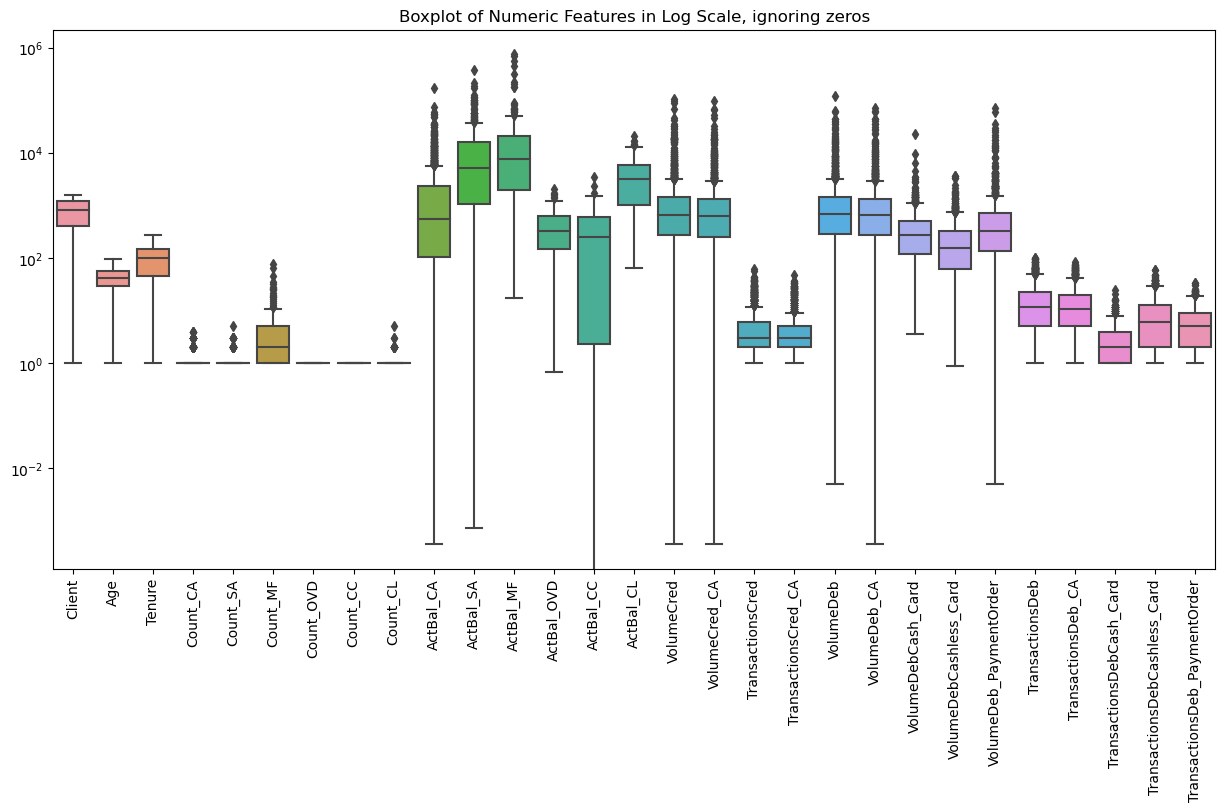

In [17]:
# Box plot for each numeric feature
# Ignore zeros
plt.figure(figsize=(15, 7))
X_numeric_no_zeros = X_numeric.copy()
for col in X_numeric_no_zeros.columns:
    X_numeric_no_zeros[col] = X_numeric_no_zeros[col].replace(0, np.nan)
sns.boxplot(data=X_numeric_no_zeros)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xticks(rotation=90)
plt.title("Boxplot of Numeric Features in Log Scale, ignoring zeros")
plt.show()


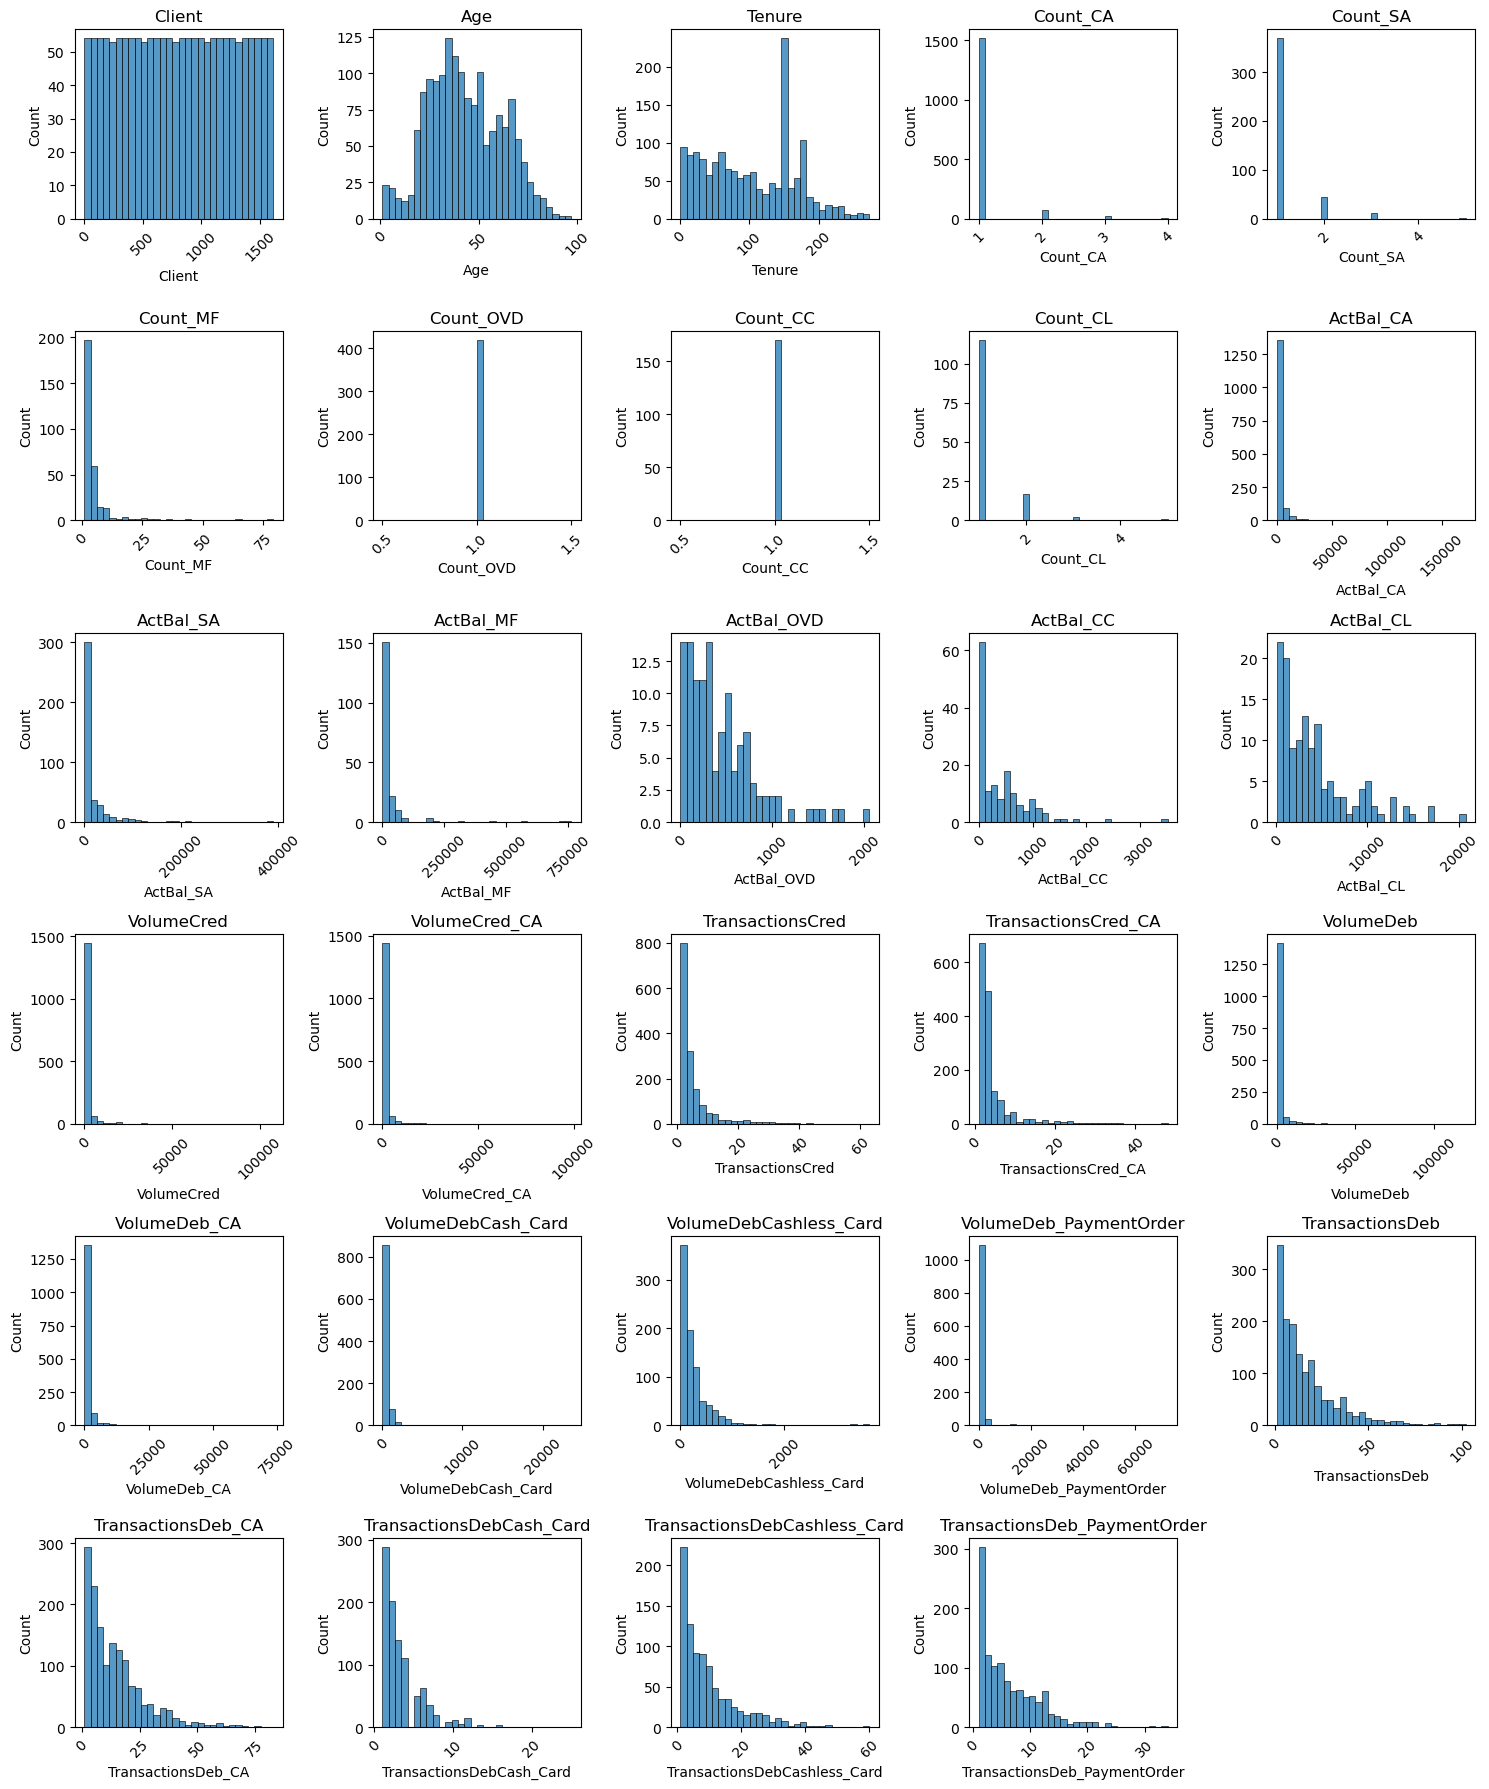

In [18]:
# Facet grid of histograms for all numeric features
# Ignore zeros
numeric_cols = [col for col in X.columns if col != 'Sex']
num_rows = (num_cols + 3) // 5  # 4 plots per row, rounded up
fig = plt.figure(figsize=(15, 3*num_rows))

for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(num_rows, 5, idx)
    sns.histplot(data=X_numeric_no_zeros[X_numeric_no_zeros[col] != 0][col], bins=30, kde=False)
    plt.title(col)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [19]:
# Calculate the percentage of outliers in each numeric feature
Q1 = X_numeric_no_zeros.quantile(0.25)
Q3 = X_numeric_no_zeros.quantile(0.75)
IQR = Q3 - Q1

# outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = ((X_numeric_no_zeros < lower_bound) | (X_numeric_no_zeros > upper_bound)).sum()
outlier_pct = (outliers / len(X_numeric_no_zeros)) * 100
print("Outlier %:")
print(outlier_pct)


Outlier %:
Client                          0.000000
Age                             0.000000
Tenure                          0.000000
Count_CA                        6.191950
Count_SA                        3.529412
Count_MF                        1.300310
Count_OVD                       0.000000
Count_CC                        0.000000
Count_CL                        1.238390
ActBal_CA                       9.969040
ActBal_SA                       2.786378
ActBal_MF                       1.362229
ActBal_OVD                      0.371517
ActBal_CC                       0.185759
ActBal_CL                       0.371517
VolumeCred                      9.969040
VolumeCred_CA                   8.049536
TransactionsCred                8.854489
TransactionsCred_CA             8.111455
VolumeDeb                       8.668731
VolumeDeb_CA                    7.182663
VolumeDebCash_Card              3.405573
VolumeDebCashless_Card          4.024768
VolumeDeb_PaymentOrder          6.687307
Trans

We can see some substantial number of outliers in the continuous numerical features in the data. To handle this, I will apply **winsorization**, i.e., I cap the values at both the 5th and 95th percentiles. However, since our financial data shows strong right-skew (many small values, few very large values) on account balances and transactions, it makes sense to only cap the upper extreme values at the 95th percentile to preserve the natural distribution while removing potential outliers by adjusting their values down to the 95th percentile value. Based on model performance, I'll know if I need to revisit this step again.

In [20]:
# Winsorization (upper half cap)
for col in (ActBal_list + VolumeCred_list + VolumeDeb_list):
    upper_cap = X[col].quantile(0.95)
    X[col] = np.clip(X[col], None, upper_cap)

# Update intermediary variables
X_numeric = X.select_dtypes(include=['number'])
X_numeric_no_zeros = X_numeric.copy()
for col in X_numeric_no_zeros.columns:
    X_numeric_no_zeros[col] = X_numeric_no_zeros[col].replace(0, np.nan)


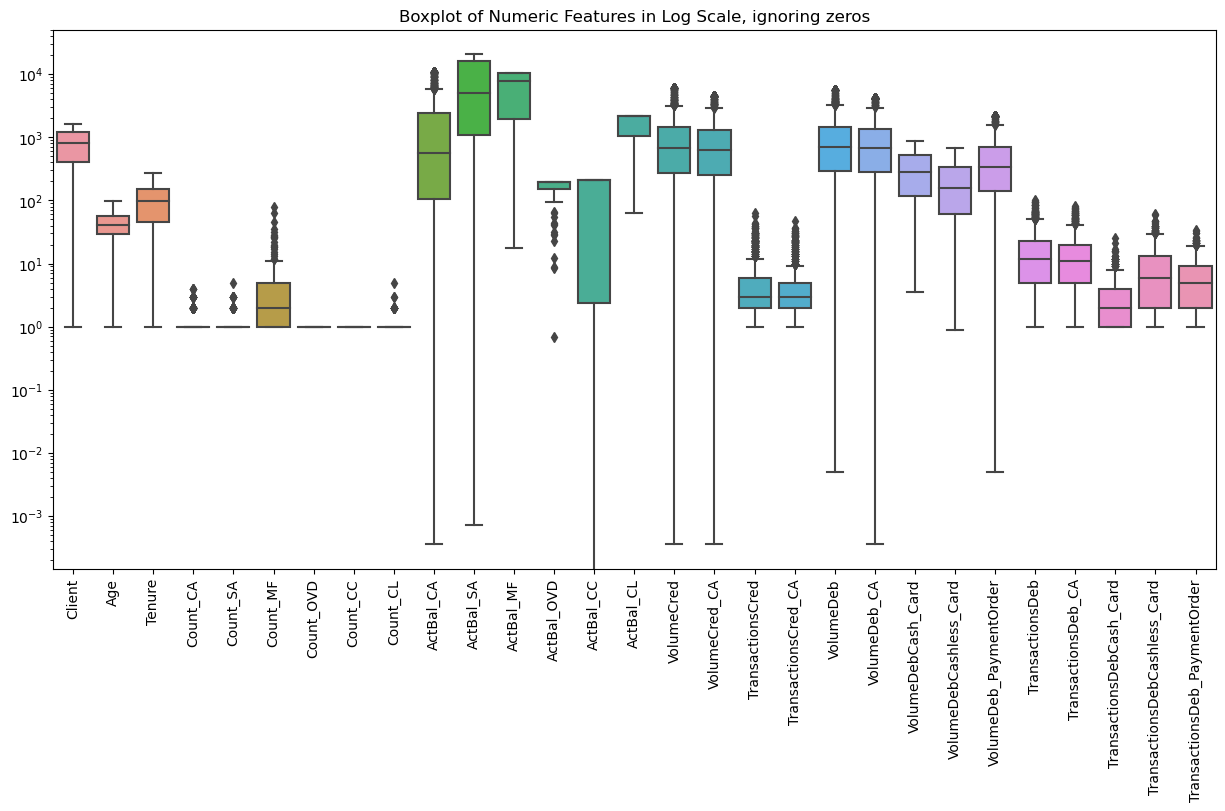

In [21]:
# Plot the Box plot again for each numeric feature
# Ignore zeros
plt.figure(figsize=(15, 7))
X_numeric_no_zeros = X_numeric.copy()
for col in X_numeric_no_zeros.columns:
    X_numeric_no_zeros[col] = X_numeric_no_zeros[col].replace(0, np.nan)
sns.boxplot(data=X_numeric_no_zeros)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xticks(rotation=90)
plt.title("Boxplot of Numeric Features in Log Scale, ignoring zeros")
plt.show()


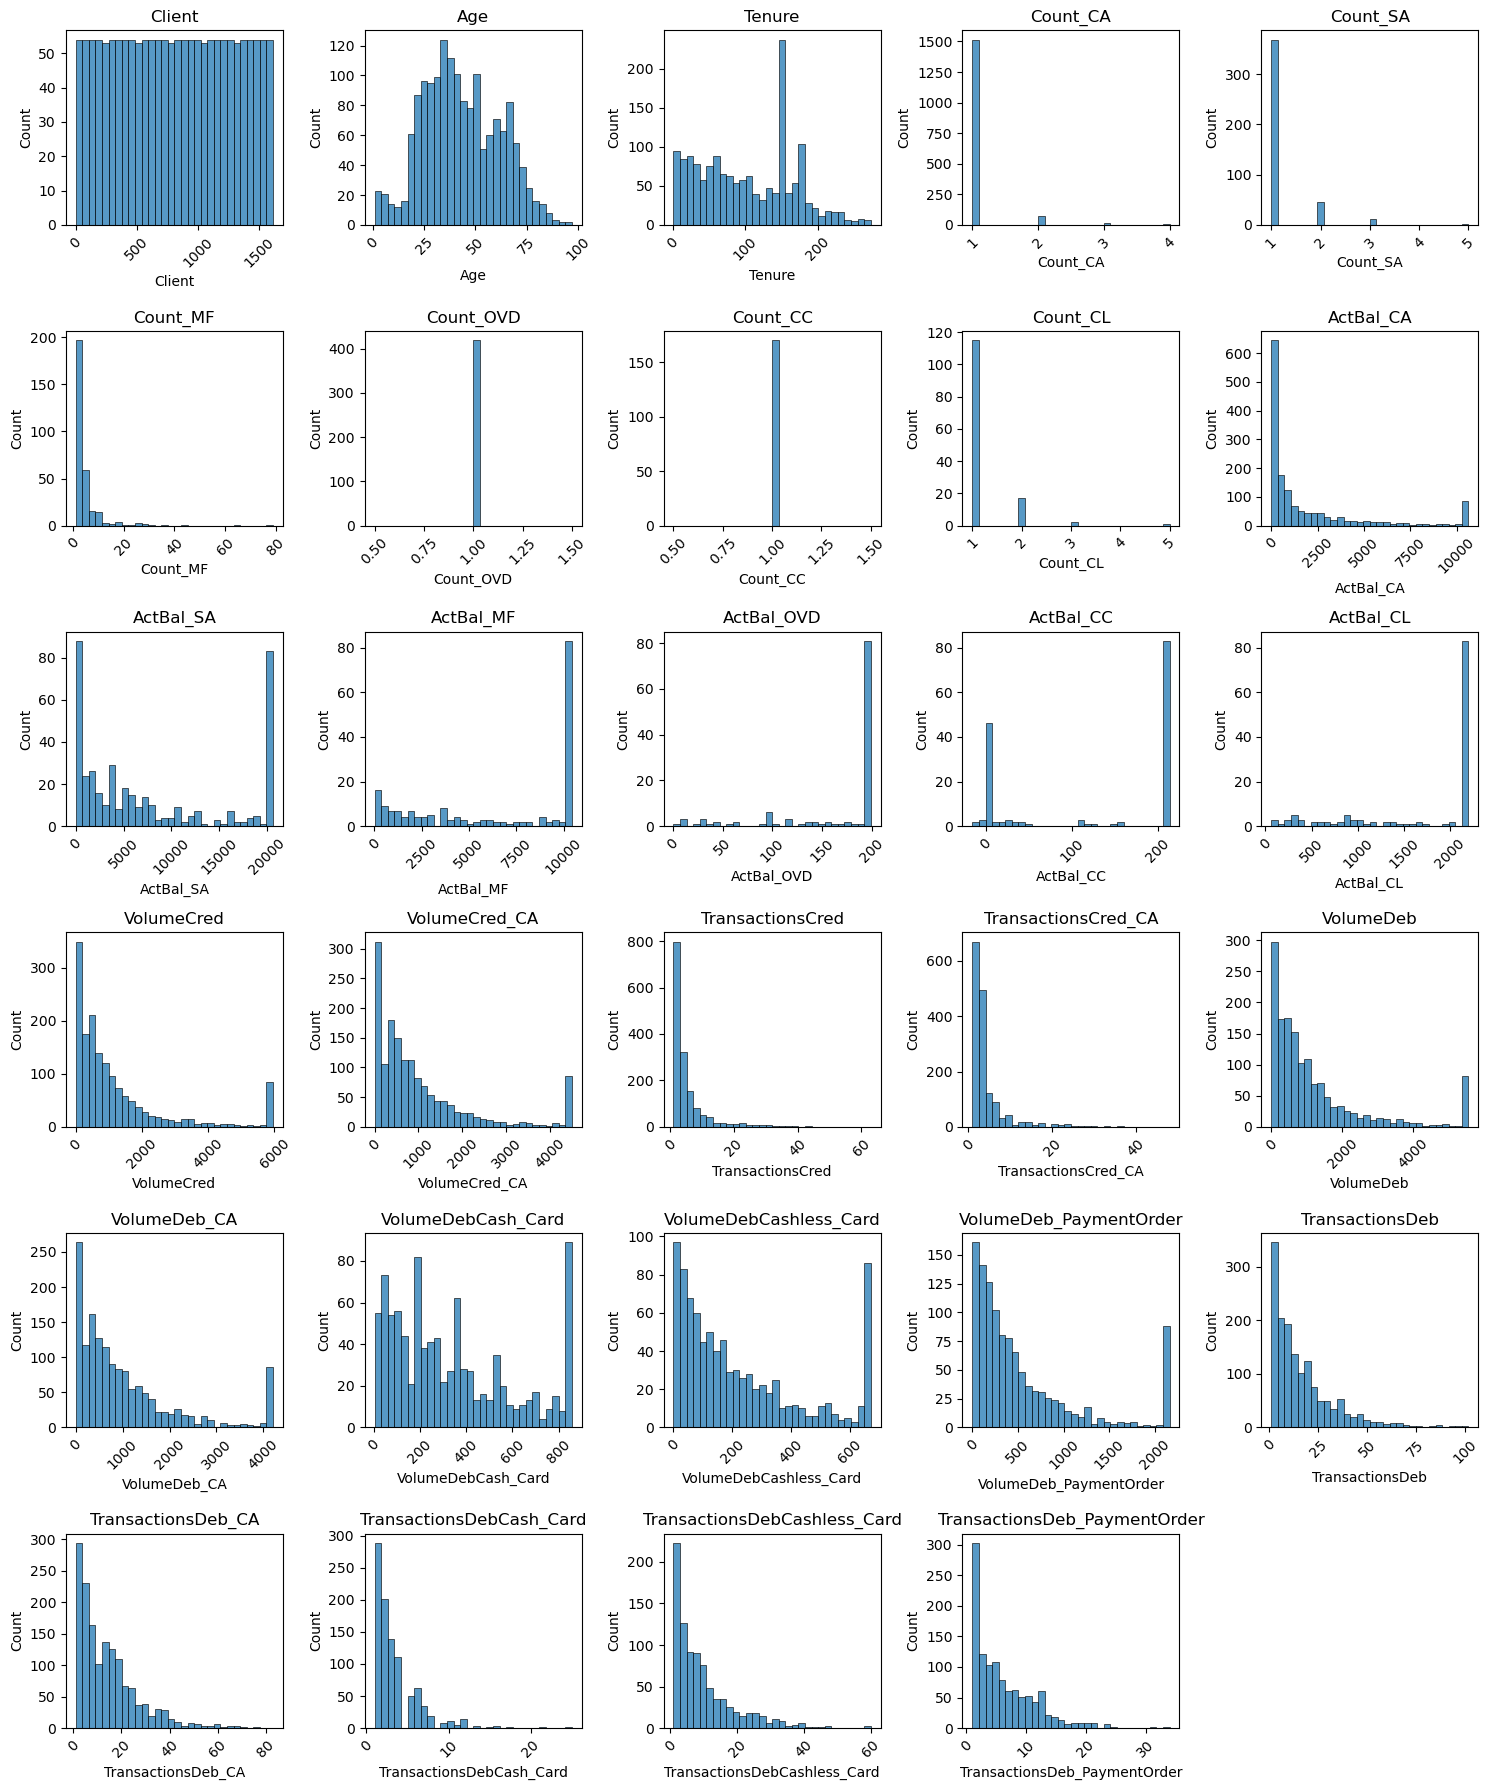

In [22]:
# Facet grid of histograms for all numeric features
# Ignore zeros
numeric_cols = [col for col in X.columns if col != 'Sex']
num_rows = (num_cols + 3) // 5  # 4 plots per row, rounded up
fig = plt.figure(figsize=(15, 3*num_rows))

for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(num_rows, 5, idx)
    sns.histplot(data=X_numeric_no_zeros[X_numeric_no_zeros[col] != 0][col], bins=30, kde=False)
    plt.title(col)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Individual Inspection: "Age" feature

In [23]:
X[X.Age <= 16].sort_values(by='Age', ascending=True)

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
157,158,M,0,152,1,1.0,0.0,0.0,0.0,0.0,...,1208.428214,1208.428214,0.000000,670.896071,0.000000,13.0,13.0,0.0,13.0,0.0
321,322,F,1,92,1,1.0,0.0,0.0,0.0,0.0,...,919.821429,919.821429,0.000000,0.000000,0.000000,2.0,2.0,0.0,0.0,0.0
390,391,M,1,16,1,0.0,0.0,0.0,1.0,1.0,...,565.791429,504.821071,178.571429,0.000000,137.678571,31.0,18.0,4.0,0.0,6.0
1081,1082,M,1,150,1,0.0,0.0,0.0,0.0,0.0,...,1944.868214,1944.868214,564.367857,98.071429,1273.678571,30.0,30.0,7.0,6.0,10.0
315,316,F,1,211,1,0.0,0.0,0.0,0.0,0.0,...,1026.817857,1026.817857,535.714286,7.710714,481.464286,21.0,21.0,6.0,1.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1328,1329,F,16,149,1,0.0,45.0,0.0,0.0,0.0,...,2479.685000,2479.685000,714.285714,131.864286,1628.749286,32.0,32.0,3.0,8.0,20.0
338,339,M,16,60,1,0.0,0.0,0.0,0.0,0.0,...,350.307500,350.307500,46.428571,303.878929,0.000000,29.0,29.0,4.0,25.0,0.0
1151,1152,M,16,179,1,0.0,0.0,0.0,0.0,0.0,...,151.828571,151.828571,17.857143,115.471429,16.321429,12.0,12.0,1.0,9.0,1.0
188,189,M,16,22,2,0.0,0.0,0.0,0.0,1.0,...,113.285714,106.250000,0.000000,0.000000,0.000000,4.0,2.0,0.0,0.0,0.0


Here, I identified 109 records corresponding to individuals aged 16 or younger, including one instance of age 0. This may be unusual and may raise some red flags depending on the context of the dataset, such as error in the data records or fraudulent accounts.

However, given that the data are denominated in EURO, **I will assume that the dataset is derived from a bank in a country in Europe where such age requirement does not exist** (perhaps the bank allows legal custodians to register in behalf of their child). So I'll treat these entries points as valid data.

#### VI. Feature Engineering

I'll create a few more meaningful features that can be derived from the existing data. These may help improve model performance.

In [24]:
# Indicator for the dormant accounts I identified earlier
X['Dormant'] = X.Client.apply(lambda x : x in missing_clients)

In [25]:
# Aggregate Account Balance
X['Total_ActBal'] = X[ActBal_list].sum(axis=1)

In [26]:
# Credit-to-Debit Ratio
X['Credit_Debit_Ratio'] = X['VolumeCred'] / (X['VolumeDeb'] + 1) # +1 to avoid dividing by 0

#### VII. Label-Encode the non-numerical categorical features

In [27]:
# Encode Sex feature (F=0, M=1)
X['Sex'] = X['Sex'].map({'F': 0, 'M': 1})

#### VIII. Check for Feature Redundancy / Multi-collinearity

I'll check for multicollinearity using Pearson's correlation to find redundant features.

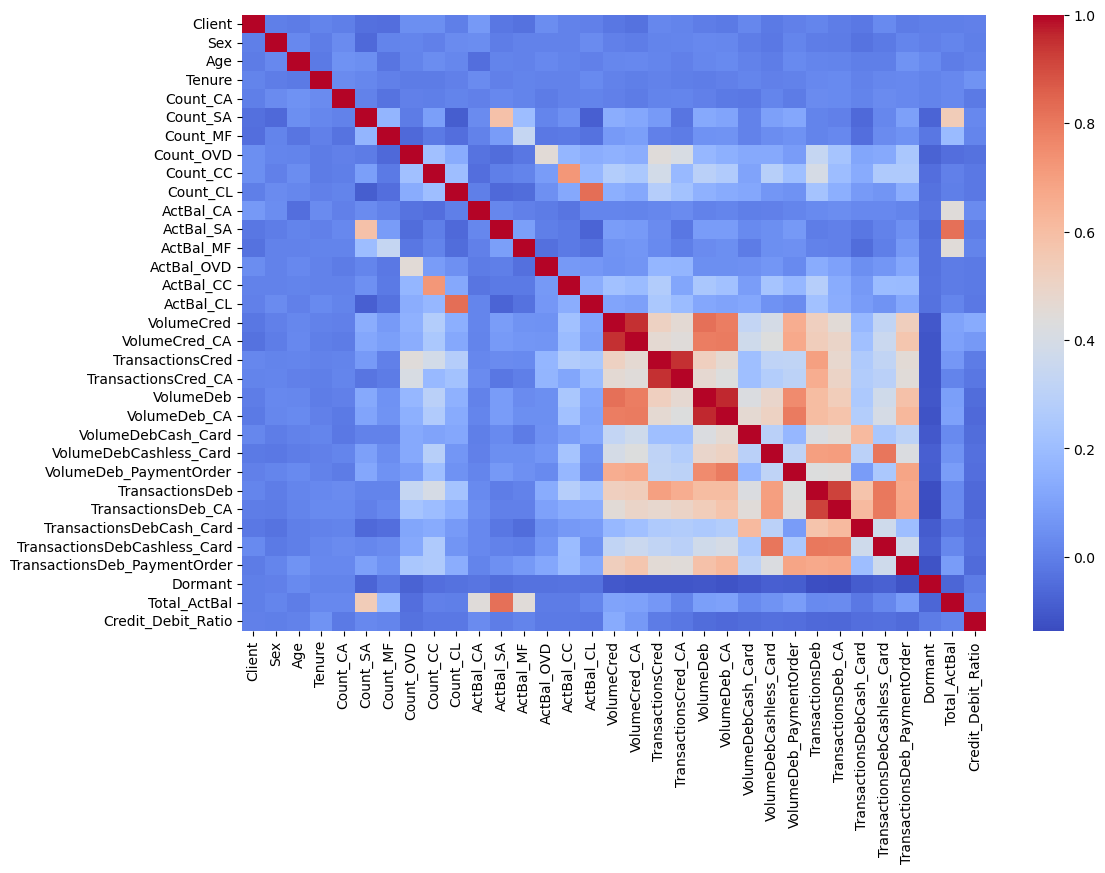

In [28]:
corr_matrix = X.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.show()

It seems like features from the Inflow_Outflow sheet with the '_CA' suffix is very highly correlated with their counterparts without the '_CA' suffix. I'll drop them from X to reduce feature redundancy.

In [29]:
# Drop columns ending with '_CA' that start with 'Volume' or 'Transactions'
ca_cols_to_drop = [col for col in X.columns if col.endswith('_CA') and 
                   (col.startswith('Volume') or col.startswith('Transactions'))]
X = X.drop(columns=ca_cols_to_drop)


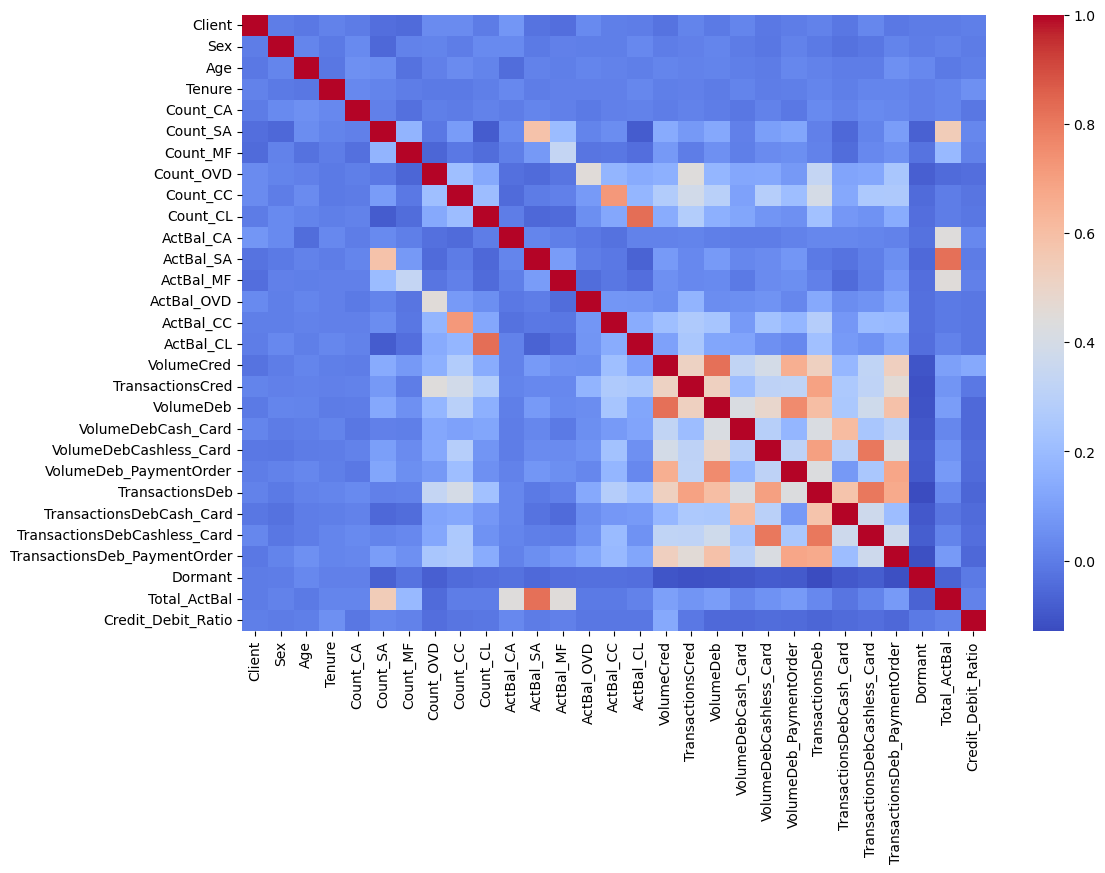

In [30]:
corr_matrix = X.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.show()

#### IX. Check for Target Class Imbalance
Sale_MF, Sale_CC, and Sale_CL represent the target labels for the classification part of the task.

In [31]:
y.head()

,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1.0,0.0,0.0,26.972679,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN


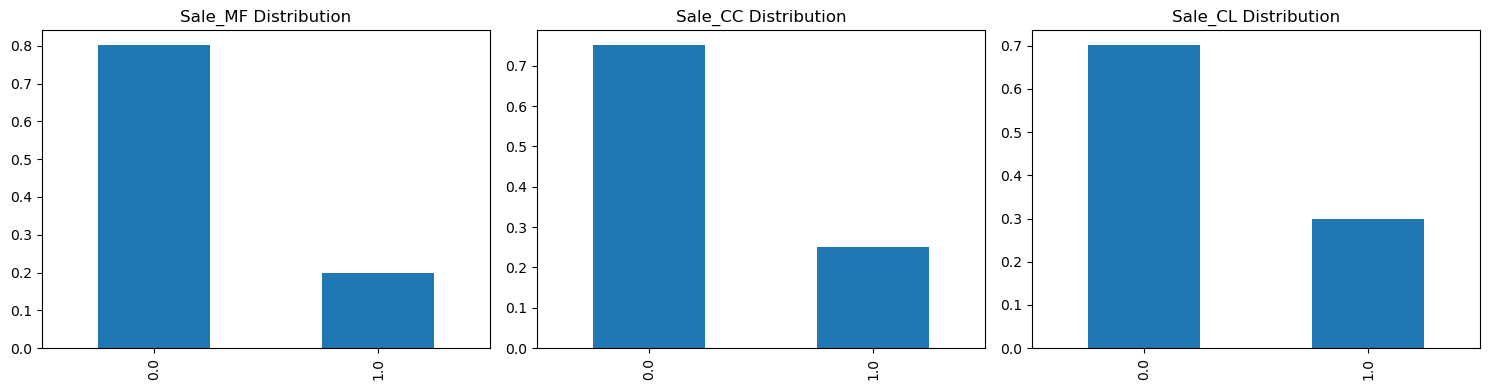

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot sales bar charts in first row
y['Sale_MF'].value_counts(normalize=True).plot(kind='bar', ax=axes[0], title='Sale_MF Distribution')
y['Sale_CC'].value_counts(normalize=True).plot(kind='bar', ax=axes[1], title='Sale_CC Distribution')
y['Sale_CL'].value_counts(normalize=True).plot(kind='bar', ax=axes[2], title='Sale_CL Distribution')

plt.tight_layout()
plt.show()


Here we see a clear imbalance in target class distribution where sales only occur around 20-30% of cases. 

However, for now, I don't need to do anything yet as I plan to train the models with adjusted class weights first and measure the performance. If that doesn't work, I can try over/undersampling.

**This concludes the eda/pre-processing stage!**

#### X. Output pre-processed data

In [33]:
X.to_csv('./data/X.csv')

In [35]:
y.to_csv('./data/y.csv')